In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Блок 1: Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from category_encoders import CatBoostEncoder
import xgboost as xgb
import os

In [3]:
# Блок 2: Завантаження даних з директорій Kaggle

train_data=pd.read_csv('https://github.com/goitacademy/MACHINE-LEARNING-NEO/blob/main/competition/final_proj_data.csv?raw=true')
test_data=pd.read_csv('https://github.com/goitacademy/MACHINE-LEARNING-NEO/blob/main/competition/final_proj_test.csv?raw=true')

In [4]:
# Блок 3: Аналіз та ознайомлення з даними

train_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,y
0,NaN,NaN,NaN,NaN,NaN,812.0,14.0,NaN,NaN,NaN,...,catzS2D,jySVZNlOJy,NaN,xG3x,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86,NaN,0
1,NaN,NaN,NaN,NaN,NaN,2688.0,7.0,NaN,NaN,NaN,...,i06ocsg,LM8l689qOp,NaN,kG3k,WqMG,RAYp,55YFVY9,mj86,NaN,0
2,NaN,NaN,NaN,NaN,NaN,1015.0,14.0,NaN,NaN,NaN,...,P6pu4Vl,LM8l689qOp,NaN,kG3k,Aoh3,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,168.0,0.0,NaN,NaN,NaN,...,BNrD3Yd,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,14.0,0.0,NaN,NaN,NaN,...,3B1QowC,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 231 entries, Var1 to y
dtypes: float64(191), int64(2), object(38)
memory usage: 17.6+ MB


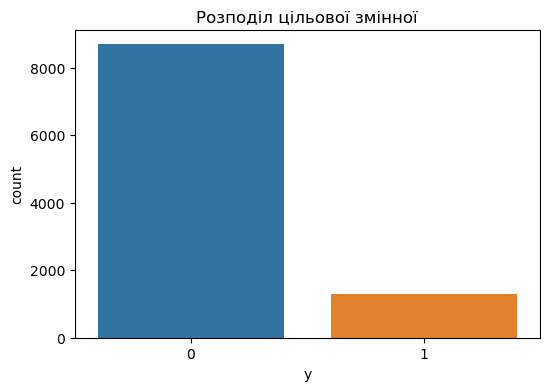

In [6]:
# Блок 4: Аналіз цільової змінної
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=train_data)
plt.title('Розподіл цільової змінної')
plt.show()


In [7]:
# Блок 5: Підготовка даних
target = train_data['y']
train_data = train_data.drop(columns=['y'])
train_data.replace(0, np.nan, inplace=True)

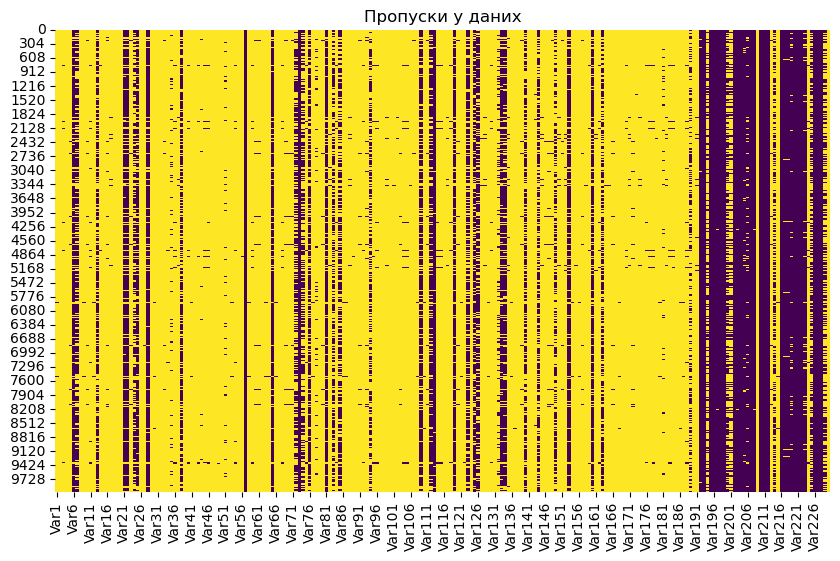

In [8]:
# Блок 6: Візуалізація пропусків у даних
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Пропуски у даних')
plt.show()

In [9]:
# Блок 7: Визначення типів ознак
numeric_features = train_data.select_dtypes(include=[np.number]).columns
categorical_features = train_data.select_dtypes(exclude=[np.number, 'bool']).columns

In [10]:
# Блок 8: Кодування та імпутація пропусків
catboost_encoder = CatBoostEncoder(cols=categorical_features)
train_data[categorical_features] = catboost_encoder.fit_transform(train_data[categorical_features], target)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(train_data)

c:\Users\Sanr\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Var2' 'Var8' 'Var15' 'Var20' 'Var31' 'Var32' 'Var39' 'Var42' 'Var48'
 'Var52' 'Var55' 'Var79' 'Var138' 'Var141' 'Var167' 'Var169' 'Var175'
 'Var185' 'Var209' 'Var230']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [11]:
# Блок 9: Розбивка даних та балансування
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, target, test_size=0.2, random_state=42)
smote = SMOTE(k_neighbors=15, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [12]:
# Блок 10: Важливість ознак та їх вибір
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train_balanced, y_train_balanced)
perm_importance = permutation_importance(model, X_valid, y_valid, n_repeats=10, random_state=42)
important_features = np.argsort(perm_importance.importances_mean)[::-1][:42]  # Топ-42 важливих ознак

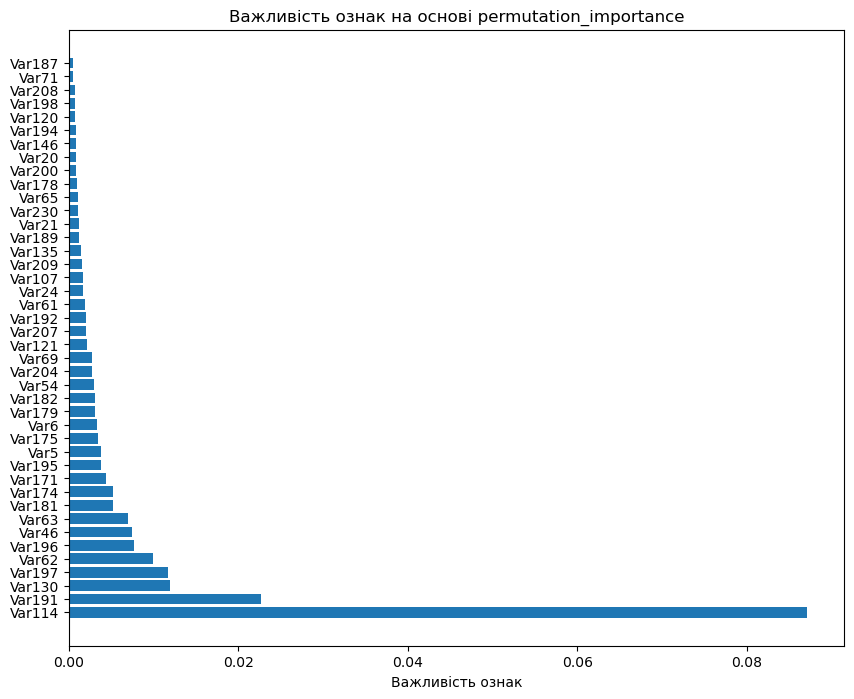

In [13]:
# Блок 11: Візуалізація важливості ознак

# Об'єднуємо числові та категоріальні ознаки в один список
all_features = list(numeric_features) + list(categorical_features)

# Перевіряємо, що індекси важливих ознак не виходять за межі доступних ознак
sorted_idx = important_features

if max(sorted_idx) < len(all_features):
    plt.figure(figsize=(10, 8))
    plt.barh(np.array(all_features)[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel('Важливість ознак')
    plt.title('Важливість ознак на основі permutation_importance')
    plt.show()
else:
    print("Індекси важливих ознак виходять за межі доступних ознак.")

In [14]:
# Блок 12: Модель XGBoost
X_train_selected = X_train_balanced[:, important_features]
X_valid_selected = X_valid[:, important_features]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
scores = cross_val_score(xgb_model, X_train_selected, y_train_balanced, cv=cv, scoring='balanced_accuracy')

print(f'Середня збалансована точність: {np.mean(scores):.4f}')
print(f'Результати крос-валідації: {scores}')

Середня збалансована точність: 0.9590
Результати крос-валідації: [0.96551724 0.95436721 0.95831887 0.95831758 0.95831836]


In [15]:
# Блок 13: Фінальне навчання та оцінка моделі
xgb_model.fit(X_train_selected, y_train_balanced)
y_pred = xgb_model.predict(X_valid_selected)
score = balanced_accuracy_score(y_valid, y_pred)
print(f'Збалансована точність на валідаційній вибірці: {score:.4f}')

Збалансована точність на валідаційній вибірці: 0.8466


In [16]:
# Блок 14: Підготовка та збереження результатів
test_data.replace(0, np.nan, inplace=True)
test_data[categorical_features] = catboost_encoder.transform(test_data[categorical_features])
test_data_imputed = imputer.transform(test_data)
preprocessed_test_data_selected = test_data_imputed[:, important_features]

test_predictions = xgb_model.predict(preprocessed_test_data_selected)
submission = pd.DataFrame({'index': test_data.index, 'y': test_predictions})
submission.to_csv('submission.csv', index=False)

c:\Users\Sanr\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Var2' 'Var8' 'Var15' 'Var20' 'Var31' 'Var32' 'Var39' 'Var42' 'Var48'
 'Var52' 'Var55' 'Var79' 'Var138' 'Var141' 'Var167' 'Var169' 'Var175'
 'Var185' 'Var209' 'Var230']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
